In [1]:
% matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from collections import OrderedDict

## View the Keys in the Imported Data

In [2]:
gen_event_ = "ttbar-100"
outfile_ = "outfile-" + gen_event_ + ".root"
data_ = uproot.open(outfile_)["ntuples"]["tree"]
# data_.keys()

## Check the Integrity of the Imported Data 

In [3]:
stereo_tp_idx_ = data_.array('stereoTPIndex')
mono_tp_idx_ = data_.array('monoTPIndex')
track_tp_idx_ = data_.array('trackTPIndex')

# Check that both have been generated for the same number of events
# Just for clarity
print len(track_tp_idx_) == len(stereo_tp_idx_),
print len(track_tp_idx_) == len(mono_tp_idx_),
print "\nTotal", len(track_tp_idx_), "events"

True True 
Total 100 events


In [4]:
# Check if any tracks map to multiple tracking particles
for i in range(len(track_tp_idx_)):
    for track_tp_list_ in track_tp_idx_[i]:
        if len(track_tp_list_) > 1:
            print "Track maps to multiple TPs in event", i

In [5]:
%%time

# Check if any hits map to multiple tracking particles
# It is NOT NECESSARY that these TPs map to actual tracks
hit_tp_count_ = {}

# Iterate over event length in mono and stereo rechits
for event_ in range(len(stereo_tp_idx_)):
    for stereo_tp_list_ in stereo_tp_idx_[event_]:
        tp_len_ = len(stereo_tp_list_)
        # Add to a dictionary of <num of TP matches : hit count>
        if tp_len_ in hit_tp_count_:
            hit_tp_count_[tp_len_] += 1
        else:
            hit_tp_count_[tp_len_] = 1
    
    for mono_tp_list_ in mono_tp_idx_[event_]:
        tp_len_ = len(mono_tp_list_)
        # Add to a dictionary of <num of TP matches : hit count>
        if tp_len_ in hit_tp_count_:
            hit_tp_count_[tp_len_] += 1
        else:
            hit_tp_count_[tp_len_] = 1

# This prints how many hits map to multiple matches
# <num matches to TPs: ncount of hits>
print "Number of matches and number of hits with those many TP matches\n", hit_tp_count_

Number of matches and number of hits with those many TP matches
{0: 166358, 1: 429164, 2: 4501, 3: 253, 4: 42, 5: 13, 6: 6, 7: 4, 8: 2, 9: 4}
CPU times: user 4.55 s, sys: 16.7 ms, total: 4.56 s
Wall time: 4.59 s


# Optimisation Tests

In [7]:
def list_to_set(input_array_):
    '''
    Format: 3-level nested lists - [[[...] ...] ...]
    '''
    output_array_ = []
    for index_ in range(len(input_array_)):
        output_array_.append([])
        for second_list_ in input_array_[index_]:
            output_array_[index_].append(set(second_list_))
    return output_array_

In [8]:
%%time 
mono_tp_idx_set_ = list_to_set(mono_tp_idx_)

CPU times: user 3.71 s, sys: 57.5 ms, total: 3.77 s
Wall time: 3.79 s


In [9]:
%%time
for event_ in range(len(track_tp_idx_)):
    for tp_list_ in track_tp_idx_[event_]:
        if len(tp_list_) > 1:
            print event_, " has a track with multiple TP matches"
        for mono_tp_list_ in mono_tp_idx_set_[event_]:
            if tp_list_[0] in mono_tp_list_:
                continue

CPU times: user 2.6 s, sys: 20.2 ms, total: 2.62 s
Wall time: 2.68 s


In [10]:
'''
Checking if each item in the lists is converted to the set
%%time
for i in range(25):
    for j in range(len(mono_tp_idx_[i])):
        for x in mono_tp_idx_[i][j]:
            if x not in mono_tp_idx_set_[i][j]:
                print 'Problem', i, j
'''

"\nChecking if each item in the lists is converted to the set\n%%time\nfor i in range(25):\n    for j in range(len(mono_tp_idx_[i])):\n        for x in mono_tp_idx_[i][j]:\n            if x not in mono_tp_idx_set_[i][j]:\n                print 'Problem', i, j\n"

## Load Data into Arrays

In [11]:
%%time
'''
Load the track parameters into the respective arrays to be added into the rechit_param_global dataframe
'''

rechit_cartesian_ = OrderedDict({})
for key in ['stereoHitX', 'stereoHitY', 'stereoHitZ', 'monoHitX', 'monoHitY', 'monoHitZ']:
    rechit_cartesian_[key] = data_.array(key)

rechit_polar_ = OrderedDict({})
for key in ['stereoHitR', 'stereoHitEta', 'stereoHitPhi', 'monoHitR', 'monoHitEta', 'monoHitPhi']:
    rechit_polar_[key] = data_.array(key)

CPU times: user 274 ms, sys: 9.02 ms, total: 283 ms
Wall time: 286 ms


## Preprocessing 1: Reformat List of Indices to Sets of Indices for each Rechit

In [51]:
%%time
# Convert all tracking particle index lists to sets for faster search

mono_tp_idx_set_ = list_to_set(mono_tp_idx_)
stereo_tp_idx_set_ = list_to_set(stereo_tp_idx_)
track_tp_idx_set_ = list_to_set(track_tp_idx_)

## Preprocessing 2: Add all data into dataframes

In [13]:
import pandas as pd
from pandas import DataFrame as df

In [14]:

'''
Dataframe column titles and datatypes

:event_id: int
:rechit_id: int
:track_id: int
:rechit_ids: list(int)
:track_ids: list(int)
:matched/unmatched_track_tp_index: set(int)  # iterating over sets has lower complexity
:rechit_tp_index: set(int)  # iterating over sets has lower complexity
:match_count: int  # count the number of rechits/tracks matched to the track/rechit
''' 

'\nDataframe column titles and datatypes\n\n:event_id: int\n:rechit_id: int\n:track_id: int\n:rechit_ids: list(int)\n:track_ids: list(int)\n:matched/unmatched_track_tp_index: set(int)  # iterating over sets has lower complexity\n:rechit_tp_index: set(int)  # iterating over sets has lower complexity\n:match_count: int  # count the number of rechits/tracks matched to the track/rechit\n'

In [15]:
%%time
'''
Adding stereo and mono rechit data into a global dataframe

:stereo/mono_tp_index_: event-based list of rechit-based list of sets of int (tp_index)

'''
def create_global_rechit_df(stereo_tp_idx_, mono_tp_idx_, rechit_cartesian_dict_, rechit_polar_dict_):
    rechit_global_map_ = OrderedDict({'event_id': [], 'rechit_id': [], 'rechit_tp_index': [],
                                      'track_matches': [], 'match_count': []})
    rechit_param_global_map_ = OrderedDict({'rechit_id':[], 'rechit_x': [], 'rechit_y': [], 'rechit_z': [], 
                                            'rechit_r': [], 'rechit_phi': [], 'rechit_eta': []})
    global_counter_ = 0
    
    if len(stereo_tp_idx_) != len(stereo_tp_idx_):
        raise ValueError('Rechit arrays represent differing event lengths [stereo, mono]:', len(stereo_tp_idx_), len(mono_tp_idx_))
    
    for event_id_ in range(len(stereo_tp_idx_)):
        # Count the number of rechits in that event
        event_rechit_count_ = len(stereo_tp_idx_[event_id_]) + len(mono_tp_idx_[event_id_])

        rechit_global_map_['event_id'].extend([event_id_] * event_rechit_count_)  
        # appends SAME instance of [event_id] event_rechit_count_ times
        
        rechit_global_map_['rechit_id'].extend(
            range(global_counter_, global_counter_ + event_rechit_count_))     
        rechit_global_map_['rechit_tp_index'].extend(stereo_tp_idx_[event_id_])
        rechit_global_map_['rechit_tp_index'].extend(mono_tp_idx_[event_id_])
        rechit_global_map_['track_matches'].extend([] for _ in range(event_rechit_count_))
        rechit_global_map_['match_count'].extend(0 for _ in range(event_rechit_count_))
        global_counter_ += event_rechit_count_
        
        # Extend the hit_param_global_map_ with rechit parameters
        rechit_param_global_map_['rechit_id'].extend(
            range(global_counter_, global_counter_ + event_rechit_count_))
        
        rechit_param_global_map_['rechit_x'].extend(rechit_cartesian_dict_['stereoHitX'][event_id_])
        rechit_param_global_map_['rechit_x'].extend(rechit_cartesian_dict_['monoHitX'][event_id_])
        rechit_param_global_map_['rechit_y'].extend(rechit_cartesian_dict_['stereoHitY'][event_id_])
        rechit_param_global_map_['rechit_y'].extend(rechit_cartesian_dict_['monoHitY'][event_id_])
        rechit_param_global_map_['rechit_z'].extend(rechit_cartesian_dict_['stereoHitZ'][event_id_])
        rechit_param_global_map_['rechit_z'].extend(rechit_cartesian_dict_['monoHitZ'][event_id_])
        
        rechit_param_global_map_['rechit_r'].extend(rechit_polar_dict_['stereoHitR'][event_id_])
        rechit_param_global_map_['rechit_r'].extend(rechit_polar_dict_['monoHitR'][event_id_])
        rechit_param_global_map_['rechit_phi'].extend(rechit_polar_dict_['stereoHitPhi'][event_id_])
        rechit_param_global_map_['rechit_phi'].extend(rechit_polar_dict_['monoHitPhi'][event_id_])
        rechit_param_global_map_['rechit_eta'].extend(rechit_polar_dict_['stereoHitEta'][event_id_])
        rechit_param_global_map_['rechit_eta'].extend(rechit_polar_dict_['monoHitEta'][event_id_])
        
    # Convert dict to dataframe
    rechit_global_df_ = df.from_dict(rechit_global_map_)
    rechit_param_global_df_ = df.from_dict(rechit_param_global_map_)
    return rechit_global_df_, rechit_param_global_df_
    
# Check Memory Usage of DataFrame
# print rechit_global_df_.memory_usage(deep=True)
# print rechit_param_global_df_.memory_usage(deep=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


In [16]:
%%time
'''
Create the Global Rechit Array and Global Rechit Parameters Array'''
rechit_global_df_, rechit_param_global_df_ = create_global_rechit_df(
    stereo_tp_idx_, mono_tp_idx_, rechit_cartesian_, rechit_polar_)
# print rechit_global_df_.head(10)

CPU times: user 13.2 s, sys: 485 ms, total: 13.7 s
Wall time: 15.2 s


In [17]:
%%time

'''
Check if/where multiple tracking particle indices occur in the rechits
This is to verify the data stored in the dict is ordered correctly
'''
'''
global_counter_ = 0

for i in range(len(stereo_tp_idx_)):
    for j in range(len(stereo_tp_idx_[i])):
        
        # If multiple matches are found in the rechits
        if len(stereo_tp_idx_[i][j]) > 1:
            print "Multiple Matches found at event", i, "rechit", j
            if rechit_global_map_["unmatched_track_tp_index"][global_counter_] == stereo_tp_idx_[i][j]:
                continue
            else:
                print "Rechit TP Index is not being stored completely/correctly in the global map"
        global_counter_ += 1
'''

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


## Match the Tracks to Rechits in a Global Array of Tracks

In [18]:
%%time
'''
Match Rechits to Tracks.
Create the Global Track Array and Global Track Parameter Array.
'''

# Initialize the Global Track Parameter Map
track_param_global_map_ = OrderedDict({})
for key in ['track_id', 'track_eta', 'track_phi', 'track_qoverp', 'track_dxy', 'track_dsz', 'track_pt']:
    track_param_global_map_[key] = []
    
# Define the dictionaries to be cast into dataframes
track_to_rechit_map_ = OrderedDict({"event_id": [], "track_id": [], "track_tp_index": [], "rechit_ids": [], "match_count": []})

# Future Requirement?
rechit_to_track_map_ = OrderedDict({"event_id": [], "rechit_id": [], "rechit_tp_index": [], "track_ids": [], "match_count": []})

# Initialize the Global Track ID
global_track_id_ = 0

for event_id_ in range(len(track_tp_idx_)):
    
    num_tracks_in_event_ = len(track_tp_idx_[event_id_])

    # Add track data to the dict in an efficient manner
    track_to_rechit_map_["event_id"].extend([event_id_] * num_tracks_in_event_)
    
    global_track_id_range_ = range(global_track_id_, global_track_id_ + num_tracks_in_event_)
    
    track_to_rechit_map_["track_id"].extend(global_track_id_range_)
    track_to_rechit_map_["track_tp_index"].extend(track_tp_idx_[event_id_])
    
    # Append multiple empty lists in place of the values not filled yet
    track_to_rechit_map_["match_count"].extend([] for _ in range(num_tracks_in_event_))
    track_to_rechit_map_["rechit_ids"].extend([] for _ in range(num_tracks_in_event_))
    
    # Fill in the Global Track Parameters
    track_param_global_map_["track_id"].extend(global_track_id_range_)
    track_param_global_map_["track_eta"].extend(data_.array('trackEta')[event_id_])
    track_param_global_map_["track_phi"].extend(data_.array('trackPhi')[event_id_])
    track_param_global_map_["track_pt"].extend(data_.array('trackPt')[event_id_])
    track_param_global_map_["track_qoverp"].extend(data_.array('qoverp')[event_id_])
    track_param_global_map_["track_dxy"].extend(data_.array('dxy')[event_id_])
    track_param_global_map_["track_dsz"].extend(data_.array('dsz')[event_id_])
    
    # Retrieve the subset of the global rechit dataframe for this event_id
    event_df_ = rechit_global_df_[rechit_global_df_['event_id']==event_id_]
    
    # Check the TPs matched to tracks and find rechits for each TP (Stereo and Mono)
    for track_tp_list_ in track_tp_idx_[event_id_]:
        rechit_matches_ = []
        
        if len(track_tp_list_) <= 1:

            # Iterate over the index and values of each rechit tp index list
            for idx_, tp_idx_list_ in event_df_['rechit_tp_index'].items():
            
                # Find the match for the first tp index in the track tp list
                if track_tp_list_[0] in tp_idx_list_:
                    rechit_matches_.append(event_df_['rechit_id'][idx_])
                
                    # Append the global track id to the rechit
                    event_df_.loc[idx_, ('track_matches')].append(global_track_id_)
                    
            track_to_rechit_map_["match_count"][global_track_id_] = len(rechit_matches_)
            track_to_rechit_map_["rechit_ids"][global_track_id_] = set(rechit_matches_)
        
        # If track has multiple tp indices, pick the one with the most hits

        # Note: This approach fails if the tp index with more rechit matches has more 
        # 'common' hits with other tracks and is later discarded due to the common hits 
        # belonging to other tracks
        if len(track_tp_list_) > 1:
            rechit_matches_array_ = []
            match_count_array_ = []
            
            print "Found multiple TP indices in event", event_id_, "for global track", 
            print global_track_id_, track_tp_list_
            
            for track_idx_ in track_tp_list_:
                rechit_matches_ = []
                
                # Iterate over the index and values of each rechit tp index list
                for idx_, tp_idx_list_ in event_df_['rechit_tp_index'].items():
                    if track_idx_ in tp_idx_list_:
                        rechit_matches_.append(event_df_['rechit_id'][idx_])
                        # Append the global track id to the rechit
                        # Append the global track id to the rechit
                        event_df_.loc[idx_, ('track_matches')].append(global_track_id_)
                        
                rechit_matches_array_.append(rechit_matches_)
                match_count_array_.append(len(rechit_matches_))
            
            # Store the global rechit ids and count of matches in a temporary list
            for key, value in zip(match_count_array_, rechit_matches_array_):
                tmp_dict_.append((key, value))
            
            # Pick the largest number of matches and corresponding global rechit ids
            tmp_dict_ = sorted(tmp_dict_, reverse=True)
            track_to_rechit_map_["match_count"][global_track_id_] = tmp_dict_[0][0]
            track_to_rechit_map_["rechit_ids"][global_track_id_] = tmp_dict_[0][1]

        # Check duplicates
        if len(set(rechit_matches_)) < len(rechit_matches_):
            raise ValueError('rechit_matches_ has duplicate values: Some Rechits are being matched twice!')
        
        # Increment the Global Track ID
        global_track_id_ += 1
    rechit_global_df_.update(event_df_, join='left')
    track_param_global_df_ = df.from_dict(track_param_global_map_)
track_global_df_ = df.from_dict(track_to_rechit_map_)

CPU times: user 21.9 s, sys: 605 ms, total: 22.5 s
Wall time: 24.6 s


In [19]:
%%time
'''
Update the match_count for rechits based on the number of matched tp_indices
'''
match_count_tmp_dict_ = OrderedDict({'match_count': [len(l) for l in rechit_global_df_['track_matches']]})
print "Maximum tracks matched for one particle:", max(match_count_tmp_dict_['match_count'])

rechit_global_df_.update(df.from_dict(match_count_tmp_dict_))
#print rechit_global_df_[rechit_global_df_['match_count'] > 1]['event_id']

Maximum tracks matched for one particle: 3
CPU times: user 270 ms, sys: 27.5 ms, total: 298 ms
Wall time: 308 ms


### Test Performance of df.loc versus multi-index retrieval [ ][ ]

In [20]:
# Create the data for testing
test_dict_ = {'sample_column':[], 'sample_column_copy':[], 'sample_column_copy_1':[]}

global_track_id_ = 999
for idx_ in range(1000):
    test_dict_['sample_column'].append([global_track_id_])
    test_dict_['sample_column_copy'].append([global_track_id_])
    test_dict_['sample_column_copy_1'].append([global_track_id_])
test_df_ = df.from_dict(test_dict_)

In [21]:
%%time
for idx_ in range(1000):
    test_df_['sample_column'][idx_].append(998)
# print test_df_.head(3)

CPU times: user 24.7 ms, sys: 3.75 ms, total: 28.5 ms
Wall time: 26 ms


In [22]:
%%time
for idx_ in range(1000):
    test_df_.loc[idx_, ('sample_column')].append(998)
# print test_df_.head(3)

CPU times: user 11.1 ms, sys: 876 µs, total: 12 ms
Wall time: 11.5 ms


## Analyse the data stored in the track_to_rechit_map_

In [23]:
for key in track_to_rechit_map_.keys():
    print key, ":", len(track_to_rechit_map_[key])

event_id : 6041
match_count : 6041
track_tp_index : 6041
rechit_ids : 6041
track_id : 6041


In [24]:
track_to_rechit_df_ = df.from_dict(track_to_rechit_map_)
track_to_rechit_df_.head(10)

# Calculate the average number of hits per track
average_rechits_per_track_ = 0
len_array_ = []
for rechit_list_ in track_to_rechit_df_['rechit_ids']:
    average_rechits_per_track_ += len(rechit_list_)
    len_array_.append(len(rechit_list_))

print "Average Rechits per track:", average_rechits_per_track_/len(track_to_rechit_df_['rechit_ids'])
print "Max. matched hits to track:", max(len_array_), "; Global track id:", len_array_.index(85)


Average Rechits per track: 12
Max. matched hits to track: 85 ; Global track id: 5


In [25]:
# Test to check if the correct tp index has been matched
# Change the value of 'trk_id_' to any track that you know has some hits
trk_id_ = 5
# print track_to_rechit_df_.loc[trk_id_]
for rechit_id in track_to_rechit_df_.loc[trk_id_]['rechit_ids']:
    for track_idx_ in track_to_rechit_df_.loc[trk_id_]['track_tp_index']:
        if track_idx_ in rechit_global_df_.loc[rechit_id]['rechit_tp_index']:
            continue
        else:
            print "Error: Track and rechit TP index does not match!"
            break

# Generate Plots

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
from matplotlib.colors import Colormap

In [27]:
#fig_ = plt.figure()
#ax_ = Axes3D(fig_)
rechit_global_df_.head()

,event_id,match_count,rechit_tp_index,track_matches,rechit_id
0,0.0,0.0,[172],[],0.0
1,0.0,0.0,[246],[],1.0
2,0.0,0.0,[246],[],2.0
3,0.0,0.0,[115],[],3.0
4,0.0,0.0,[144],[],4.0


In [28]:
# Find Number of Events based on any property length
track_eta_ = data_.array("trackEta")
print "Number of Events: ", len(track_eta_)

Number of Events:  100


### Analyse Matched/Unmatched Rechits

In [29]:
%%time
'''
Check that the count of hits entered in the dataframe match the stereo/mono hits
Count the number of matched, unmatched, and total rechits in the dataframe (PER EVENT)
'''

# TODO: Create a function of the following code that can be used for both tracks and hits
# Add a switch case for the 'assert' statements that skips
# the mono+stereo hit-sum assertion if it works with tracks instead of rechits

if len(stereo_tp_idx_) != len(mono_tp_idx_):
    raise ValueError("Number of events in stereo and mono rechits do not match!")

# Initialize one array for counts and one for ids of matched/unmatched rechits
rechit_count_ = OrderedDict({'track_matched':[], 'unmatched':[], 'tp_matched':[], 'total':[]})
rechit_ids_ = OrderedDict({'track_matched':[], 'unmatched':[]})

for event_id_ in range(len(stereo_tp_idx_)):
    # Create a slice of the dataframe with the data for that event
    event_df_ = rechit_global_df_[rechit_global_df_['event_id']==event_id_]
    
    # Count the number of matched, unmatched, and total rechits 
    num_matched_hits_ = sum(event_df_['match_count'] > 0)
    num_unmatched_hits_ = sum(event_df_['match_count'] == 0)
    num_total_hits_ = event_df_.shape[0]  # number of rows/rechits in the event
    
    # Find and store the indices of matched and unmatched rechits
    rechit_ids_['track_matched'].append(set(event_df_.loc[event_df_['match_count'] > 0, ('rechit_id')].tolist()))
    rechit_ids_['unmatched'].append(set(event_df_.loc[event_df_['match_count'] == 0, ('rechit_id')].tolist()))

    # Sanity checks to ensure data has been added into the dataframe corrrectly
    assert num_total_hits_ == (num_matched_hits_ + num_unmatched_hits_), \
    "Rechit counts (unmatched, track_matched, total) do not add up"
    
    assert (len(stereo_tp_idx_[event_id_]) + len(mono_tp_idx_[event_id_])) == num_total_hits_, \
    "Rechits in dataframe %d and stereo_tp_idx_ %d do not match" % (num_total_hits_, len(stereo_tp_idx_[event_id_]))
    
    # Append the hit counts into the dataframe
    rechit_count_['track_matched'].append(num_matched_hits_)
    rechit_count_['unmatched'].append(num_unmatched_hits_)
    rechit_count_['total'].append(num_total_hits_)
    criteria_ = [(len(x) > 0) for x in event_df_['rechit_tp_index']]
    rechit_count_['tp_matched'].append(len(event_df_[criteria_]))
    

CPU times: user 5.35 s, sys: 57.1 ms, total: 5.4 s
Wall time: 5.45 s


### Analyse the Matched/Unmatched Tracks

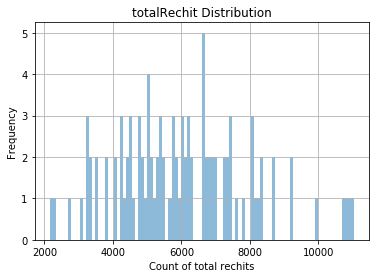

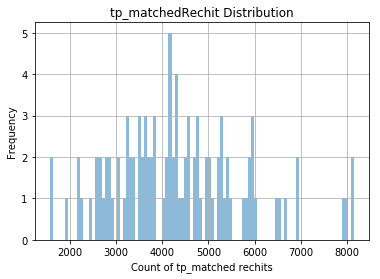

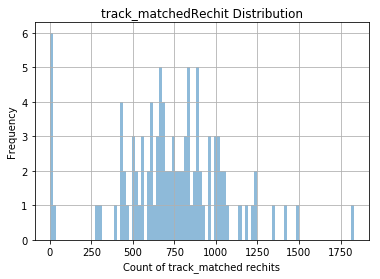

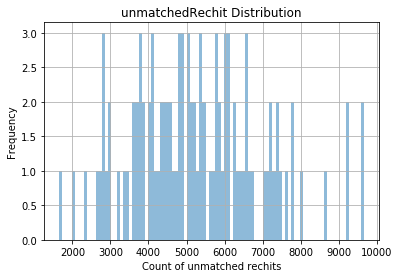

In [30]:
%matplotlib inline

for key in rechit_count_.keys():
    ax_ = plt.subplot()
    ax_.hist(rechit_count_[key], histtype='stepfilled', bins=len(rechit_count_[key]), 
             orientation='vertical', alpha=0.5)
    plt.grid(True)
    plt.ylabel('Frequency')    
    plt.xlabel('Count of ' + key + ' rechits')
    plt.title(key + 'Rechit Distribution')
    plt.savefig('plots/' + gen_event_ + '/rechits/' + key + 'rechits')
    plt.show()

### Hits matched to TP but not Tracks

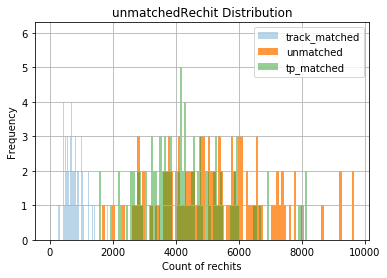

In [31]:
%matplotlib inline

for ind_1 in range(len(rechit_count_['unmatched'])):
    #for ind_2 in range(len(rechit_count_['unmatched'][ind_1])):
    if rechit_count_['tp_matched'][ind_1] > rechit_count_['unmatched'][ind_1]:
        print "Error!"

ax_ = plt.subplot()
ax_.hist(rechit_count_['track_matched'], histtype='stepfilled', bins=len(rechit_count_[key]), 
         orientation='vertical', alpha=0.3, label='track_matched')
ax_.hist(rechit_count_['unmatched'], histtype='stepfilled', bins=len(rechit_count_[key]), 
         orientation='vertical', alpha=0.8, label='unmatched')
ax_.hist(rechit_count_['tp_matched'], histtype='stepfilled', bins=len(rechit_count_[key]), 
         orientation='vertical', alpha=0.5, label='tp_matched')
plt.grid(True)
plt.legend()
plt.ylabel('Frequency')    
plt.xlabel('Count of rechits')
plt.title(key + 'Rechit Distribution')
plt.savefig('plots/' + gen_event_ + '/rechits/' + key + 'rechits')
plt.show()

In [32]:
%%time
'''
Check that track lengths in track_tp_idx_ matches track lengths per event in dataframe
Select and store matched/unmatched tracks and their ids for further analysis
'''

# TODO: Create a function of the following code that can be used for both tracks and hits
# Add a switch case for the 'assert' statements that skips
# the mono+stereo hit-sum assertion if it works with tracks instead of rechits

if len(track_tp_idx_) != len(stereo_tp_idx_):
    raise ValueError("Tracks (%d) and Stereo Rechits (%d) show different event lengths" % (len(track_tp_idx_), len(stereo_tp_idx_)))

# Initialize track data dicts
track_count_ = OrderedDict({'matched':[], 'unmatched':[], 'total':[]})
track_ids_ = OrderedDict({'matched':[], 'unmatched':[]})

for event_id_ in range(len(track_tp_idx_)):
    # Create a slice of the dataframe with the data for that event
    event_df_ = track_global_df_[track_global_df_['event_id']==event_id_]
    
    # Count the number of matched, unmatched, and total rechits 
    num_matched_tracks_ = sum(event_df_['match_count'] > 0)
    num_unmatched_tracks_ = sum(event_df_['match_count'] == 0)
    num_total_tracks_ = event_df_.shape[0]  # number of rows/rechits in the event
        
    # Find and store the indices of matched and unmatched rechits
    track_ids_['matched'].append(set(event_df_.loc[event_df_['match_count'] > 0, ('track_id')].tolist()))
    track_ids_['unmatched'].append(set(event_df_.loc[event_df_['match_count'] == 0, ('track_id')].tolist()))

    # Sanity checks to ensure data has been added into the dataframe corrrectly
    assert num_total_tracks_ == (num_matched_tracks_ + num_unmatched_tracks_), \
    "Track counts (unmatched, matched, total) do not add up"
    
    assert len(track_tp_idx_[event_id_]) == num_total_tracks_, \
    "Tracks in dataframe %d and track_tp_idx_ %d do not match" % (num_total_tracks_, len(track_tp_idx_[event_id_]))
    
    # Append the hit counts into the dataframe
    track_count_['matched'].append(num_matched_tracks_)
    track_count_['unmatched'].append(num_unmatched_tracks_)
    track_count_['total'].append(num_total_tracks_)
      

CPU times: user 484 ms, sys: 10.9 ms, total: 495 ms
Wall time: 625 ms


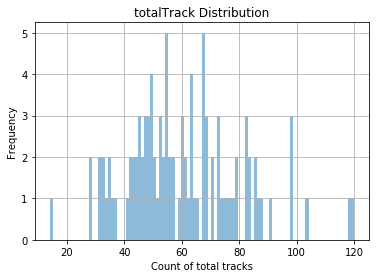

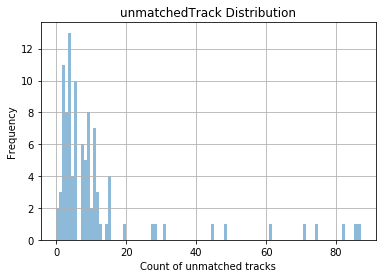

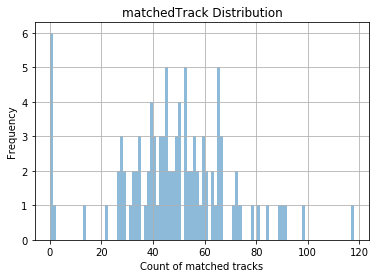

In [33]:
%matplotlib inline

for key in track_count_.keys():
    ax_ = plt.subplot()
    ax_.hist(track_count_[key], histtype='stepfilled', bins=len(track_count_[key]), orientation='vertical', alpha=0.5)
    plt.grid(True)
    plt.ylabel('Frequency')    
    plt.xlabel('Count of ' + key + ' tracks')
    plt.title(key + 'Track Distribution')
    plt.savefig('plots/' + gen_event_ + '/track/' + key + 'tracks')
    plt.show()

In [34]:
%%time

'''
Calculate the difference in track and rechit eta per event
Note: Gets Rechit Eta Values from Rechit Global DF
'''

# lists of delta-eta between tracks and matched rechits indexed by global_track_id
# also contains the mean of these values stored in a separate array using index 'mean_difference'
matched_track_eta_difference_ = {}

for event_id_ in range(len(track_tp_idx_)):
    #event_df_ = track_global_df_[track_global_df_['event_id']==event_id_]
    # iterate over the selected tracks and the rechit ids matched to each track
    matched_track_eta_difference_[event_id_] = {}
    for track_id_ in track_ids_['matched'][event_id_]:
        trk_eta_diff_ = []
        track_id_ = int(track_id_)
        # Retrieve eta for the track
        trk_eta_ = track_param_global_df_.iloc[track_id_]['track_eta']
        rechit_ids_for_track_ = track_global_df_.iloc[track_id_]['rechit_ids']
        for rechit_id_ in rechit_ids_for_track_:
            rechit_id_ = int(rechit_id_)
            trk_eta_diff_.append(trk_eta_ - rechit_param_global_df_.iloc[rechit_id_]['rechit_eta'])
        matched_track_eta_difference_[event_id_][track_id_] = trk_eta_diff_
    matched_track_eta_difference_[event_id_]['mean_difference'] = [sum(diff_list_)/len(diff_list_) for diff_list_ in matched_track_eta_difference_[event_id_].values()] 
    


CPU times: user 12.8 s, sys: 113 ms, total: 13 s
Wall time: 13 s


In [35]:
# TODO: Plot interactive histogram
# plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) + cycler('alpha', ['0.2', '0.4', '0.6', '0.8'])))
# print rechit_param_global_df_.iloc[:50]['rechit_eta']

for event_id_ in range(len(matched_track_eta_difference_.keys())):
    if len(matched_track_eta_difference_[event_id_]['mean_difference']) == 0:
        continue
    ax_ = plt.subplot()
    ax_.hist(matched_track_eta_difference_[event_id_]['mean_difference'], histtype='stepfilled', 
             bins=len(matched_track_eta_difference_[event_id_]['mean_difference']), 
             orientation='vertical')
    plt.grid(True)
    plt.ylabel('Frequency')    
    plt.xlabel('Rechit difference')
    plt.title('Rechit vs. Track eta-difference Distribution for event ' + str(event_id_))
    #plt.savefig('plots/' + gen_event_ + '/track/' + key + 'tracks')
    #plt.show()
    #plt.pause(2)
    plt.clf()

<Figure size 432x288 with 0 Axes>

# Track Parameters

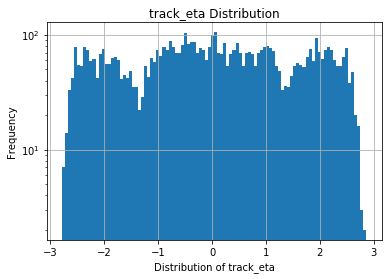

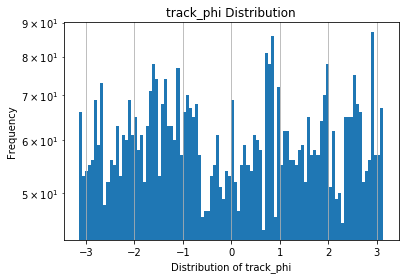

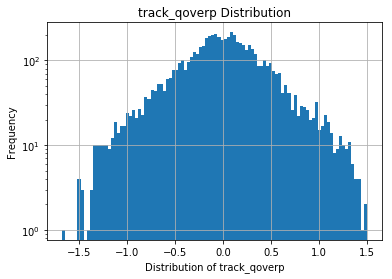

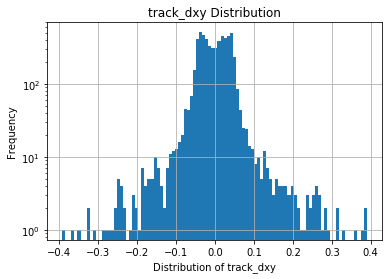

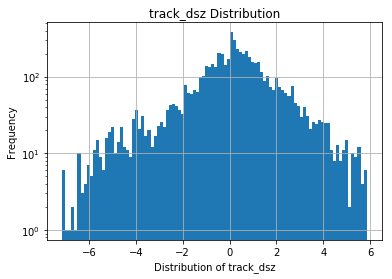

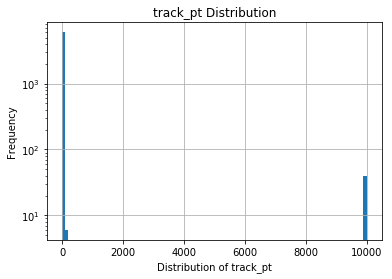

In [36]:
%matplotlib inline
# Iterate over 5 track parameters and plot their distribution
# Note: THIS IS LOG SCALE

for key in track_param_global_df_.columns:
    if key == 'track_id':
        continue
    ax_ = plt.subplot()
    ax_.hist(track_param_global_df_[key], histtype='stepfilled', bins=100, orientation='vertical')
    plt.grid(True)
    plt.ylabel('Frequency')
    
    # Comment the next line for a linear scale
    plt.yscale('log')
    
    plt.xlabel('Distribution of ' + key)
    plt.title(key + ' Distribution')
    plt.savefig('plots/' + gen_event_ + '/track/' + key)
    plt.show()

Iterating over track pt from 6041 tracks


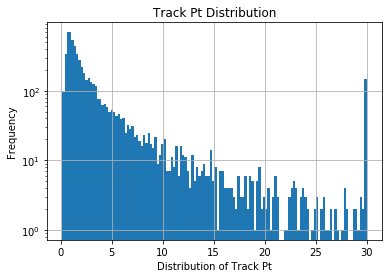

In [37]:
# Additional visualization discarding high-pt events for more clarity

track_pt_ = data_.array('trackPt')
concat_track_pt_ = []
high_pt_events_ = {}

for event_ in range(len(track_pt_)):
    for trk_pt_val_ in track_pt_[event_]:
        
        # What is a reasonable general threshold for Track Pt?
        if trk_pt_val_ < 30:
            concat_track_pt_.append(trk_pt_val_)
        else:
            if event_ in high_pt_events_:
                high_pt_events_[event_] += 1
            else:
                high_pt_events_[event_] = 1
            concat_track_pt_.append(30)
            
print "Iterating over track pt from", len(concat_track_pt_), "tracks"

plt.clf()
ax_ = plt.subplot()
ax_.hist(concat_track_pt_, histtype='stepfilled', bins=len(high_pt_events_.keys())*2, orientation='vertical')
plt.grid(True)
plt.ylabel('Frequency')
plt.yscale('log')
plt.xlabel('Distribution of Track Pt')
plt.title('Track Pt Distribution')
plt.savefig('plots/' + gen_event_ + '/track/track-pt')
plt.show()

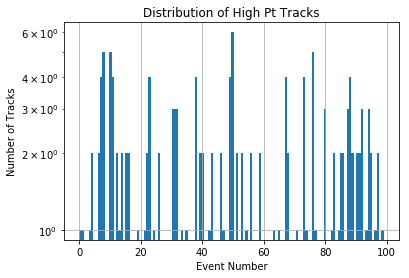

In [38]:
# Events with high pt tracks and their distribution

plt.clf()
ax_ = plt.subplot()
ax_.hist(high_pt_events_.keys(), weights=high_pt_events_.values(), bins=len(high_pt_events_.keys())*2, orientation='vertical')
plt.grid(True)
plt.ylabel('Number of Tracks')
plt.yscale('log')
plt.xlabel('Event Number')
plt.title('Distribution of High Pt Tracks')
plt.savefig('plots/' + gen_event_ + '/track/high-pt-events')
plt.show()


3428


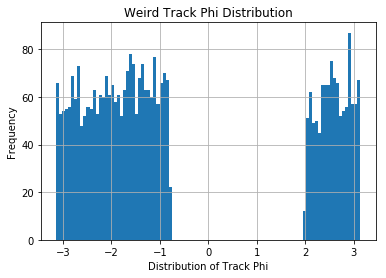

In [39]:
# Input the range of values with odd track phi in case it is a specific part

# Note: This is ONLY useful if there is a 'sub-portion' of the graph that is weird-looking
# If it is oddly distributed throughout, an alternative means of visualization is needed

track_phi_ = data_.array('trackPhi')
concat_track_phi_ = []
anomalous_phi_event_number_ = {}
for event_ in range(len(track_phi_)):
    
    for phi_idx_ in range(len(track_phi_[event_])):
        
        if (track_phi_[event_][phi_idx_] >= -0.8) and (track_phi_[event_][phi_idx_] <= 2):
            if event_ in anomalous_phi_event_number_:
                anomalous_phi_event_number_[event_] += 1
            else:
                anomalous_phi_event_number_[event_] = 1
            continue
        else:    
            concat_track_phi_.append(track_phi_[event_][phi_idx_])
        
print len(concat_track_phi_)
ax_ = plt.subplot()
ax_.hist(concat_track_phi_, histtype='stepfilled', bins=100, orientation='vertical')
plt.grid(True)
plt.ylabel('Frequency')
plt.xlabel('Distribution of Track Phi')
plt.title('Weird Track Phi Distribution')
plt.show()

{0: 29, 1: 16, 2: 33, 3: 45, 4: 16, 5: 35, 6: 27, 7: 36, 8: 22, 9: 14, 10: 22, 11: 42, 12: 20, 13: 6, 14: 48, 15: 33, 16: 35, 17: 36, 18: 14, 19: 42, 20: 25, 21: 28, 22: 36, 23: 35, 24: 20, 25: 38, 26: 27, 27: 22, 28: 25, 29: 29, 30: 27, 31: 35, 32: 15, 33: 12, 34: 35, 35: 18, 36: 13, 37: 23, 38: 29, 39: 19, 40: 52, 41: 11, 42: 41, 43: 12, 44: 21, 45: 32, 46: 12, 47: 29, 48: 25, 49: 24, 50: 32, 51: 14, 52: 26, 53: 28, 54: 35, 55: 46, 56: 24, 57: 42, 58: 20, 59: 30, 60: 34, 61: 29, 62: 10, 63: 24, 64: 47, 65: 37, 66: 40, 67: 25, 68: 32, 69: 26, 70: 20, 71: 15, 72: 23, 73: 24, 74: 14, 75: 21, 76: 36, 77: 21, 78: 12, 79: 34, 80: 20, 81: 24, 82: 30, 83: 16, 84: 23, 85: 23, 86: 31, 87: 31, 88: 41, 89: 14, 90: 21, 91: 33, 92: 9, 93: 13, 94: 26, 95: 20, 96: 16, 97: 25, 98: 18, 99: 17}


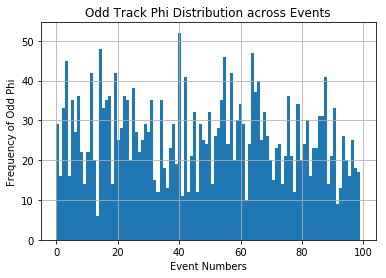

In [40]:
# Plot histogram of events with oddly distributed track phi
print anomalous_phi_event_number_
odd_phi_count_ = anomalous_phi_event_number_.values()
x_index_ = range(len(odd_phi_count_))
# print anomalous_phi_event_number_
ax_ = plt.subplot()
ax_.hist(x_index_, weights=odd_phi_count_, bins=100, orientation='vertical')
plt.grid(True)
plt.ylabel('Frequency of Odd Phi')
plt.xlabel('Event Numbers')
plt.title('Odd Track Phi Distribution across Events')
plt.show()

Added 6041 tracks from 100 events


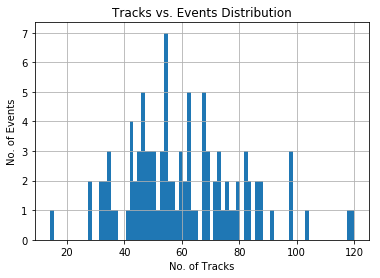

In [41]:
# Plot the distribution of tracks in events 
# using the length of any paramater array - e.g. track eta

track_Eta_ = data_.array("trackEta")
concat_num_tracks_ = []

for i in range(len(track_Eta_)):
     concat_num_tracks_.append(len(track_Eta_[i]))
print "Added", sum(concat_num_tracks_), "tracks from", len(concat_num_tracks_), "events"
ax_ = plt.subplot()
ax_.hist(concat_num_tracks_, histtype='bar', bins=80, align='mid', orientation='vertical')

plt.xlabel('No. of Tracks')
plt.ylabel('No. of Events')
plt.title('Tracks vs. Events Distribution')
plt.grid(True)
plt.savefig('plots/' + gen_event_ + '/track/event-track-distribution')
plt.show()

# Plot SimHit Distribution in X and Y Axes

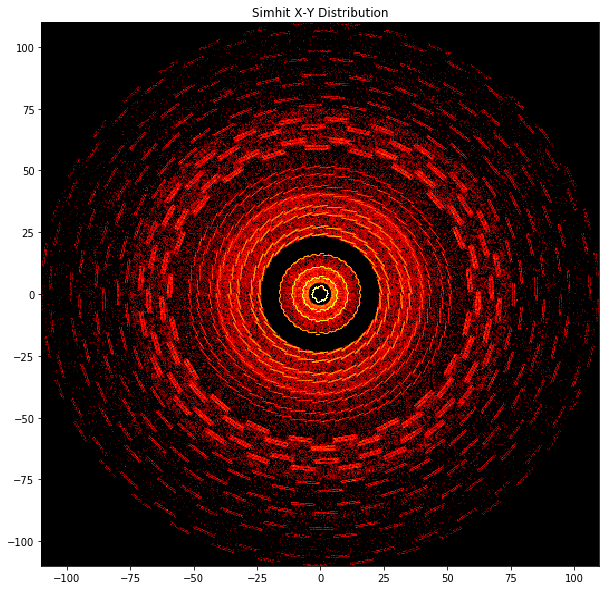

In [42]:
simhit_x_ = data_.array('simHitX')
simhit_y_ = data_.array('simHitY')
simhit_z_ = data_.array('simHitZ')

# Append all simhits into a single array for plotting
if len(simhit_x_) == len(simhit_y_):
    concat_simhit_x_ = []
    concat_simhit_y_ = []

    for i in range(len(simhit_x_)):
        concat_simhit_x_.extend(simhit_x_[i])
        concat_simhit_y_.extend(simhit_y_[i])

plt.figure(figsize=(10, 10))
ax_ = plt.subplot(1,1,1)
# Plot the 2D Histogram for Simhits
plt.title('Simhit X-Y Distribution')
ax_.patch.set_facecolor('black')
plt.hist2d(concat_simhit_x_, concat_simhit_y_, bins=500, norm=matplotlib.colors.LogNorm(), cmap='hot')
plt.savefig('plots/' + gen_event_ + '/sim/hitdistribution')
plt.show()

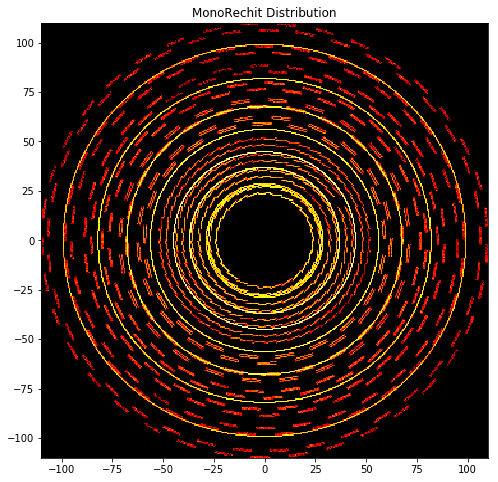

In [43]:
# ToDo: Add lognorm colormap

mono_x_ = data_.array("monoHitX") 
mono_y_ = data_.array("monoHitY")
mono_z_ = data_.array("monoHitZ")

# Append all mono rehits into a single array for plotting
if len(mono_x_) == len(mono_y_):
    concat_mono_x_ = []
    concat_mono_y_ = []

    for i in range(len(mono_x_)):
        concat_mono_x_.extend(mono_x_[i])
        concat_mono_y_.extend(mono_y_[i])

plt.figure(figsize=(8,8))
ax_ = plt.subplot(1,1,1)
# Plot the 2D Histogram for Mono Rechits
plt.title('MonoRechit Distribution')
ax_.patch.set_facecolor('black')
plt.hist2d(concat_mono_x_, concat_mono_y_, bins=350, norm=matplotlib.colors.LogNorm(), cmap='hot')
plt.savefig('plots/' + gen_event_ + '/stereo/rechitdistribution')
plt.show()

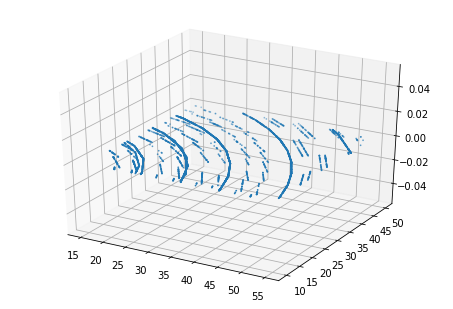

In [44]:
%matplotlib inline

# Trying to explore the hole in 3 dimensions
# Not quite possible to do manually?
fig_ = plt.figure()
ax_ = Axes3D(fig_)
concat_mono_x_ = []
concat_mono_y_ = []
concat_mono_z_ = []

for event_ in range(10):
    for x, y, z, in zip(mono_x_[event_], mono_y_[event_], mono_z_[event_]):
        if x < 55 and x > 15 and y > 10 and y < 50:
            concat_mono_x_.append(x)
            concat_mono_y_.append(y)
            concat_mono_z_.append(z)   

ax_.scatter3D(concat_mono_x_, concat_mono_y_, s=0.6)
#ax_.scatter3D(concat_mono_x_, concat_mono_y_, concat_mono_z_, s=0.6)

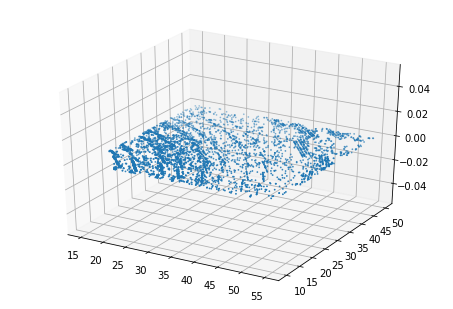

In [45]:
% matplotlib inline
# Trying to explore the hole in 3 dimensions
# Not quite possible to do manually?

fig_ = plt.figure()
ax_ = Axes3D(fig_)

concat_simhit_x_ = []
concat_simhit_y_ = []
concat_simhit_z_ = []

for event_ in range(8):
    for x, y, z, in zip(simhit_x_[event_], simhit_y_[event_], simhit_z_[event_]):
        if x < 55 and x > 15 and y > 10 and y < 50:
            concat_simhit_x_.append(x)
            concat_simhit_y_.append(y)
            concat_simhit_z_.append(z)   

ax_.scatter3D(concat_simhit_x_, concat_simhit_y_, s=0.6)  # Better visualization
# ax_.scatter3D(concat_simhit_x_, concat_simhit_y_, concat_simhit_z_, s=0.6)

<Figure size 432x288 with 0 Axes>

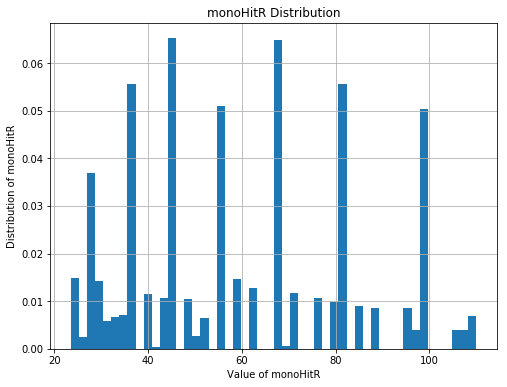

<Figure size 432x288 with 0 Axes>

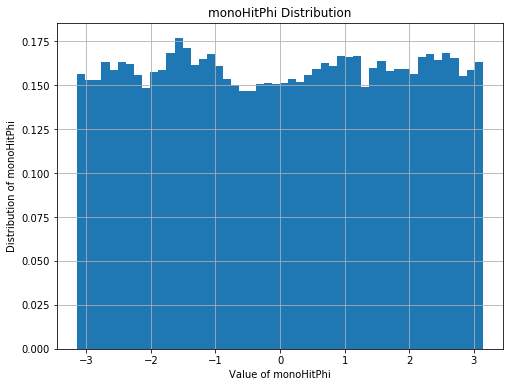

<Figure size 432x288 with 0 Axes>

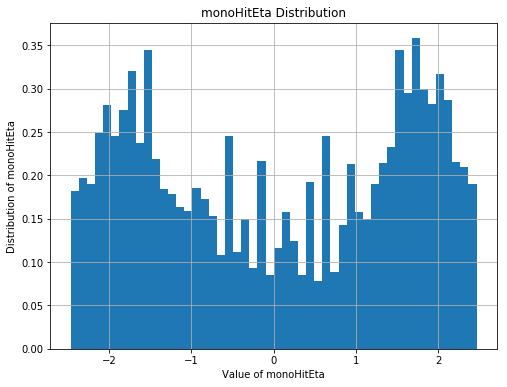

In [46]:
%matplotlib inline

# Define a loop that plots R, Phi, and Eta for Mono Hits
position_ = 1
for param in ["monoHitR", "monoHitPhi", "monoHitEta"]:
    mono_param_ = data_.array(param)
    concat_mono_param_ = []
    
    for i in range(len(mono_param_)):
            concat_mono_param_.extend(mono_param_[i])

    plt.clf()
    fig, ax_ = plt.subplots(figsize=(8, 6))
    position_ += 1
    # Plot the 2D Histogram for Mono Rechits
    ax_.set_title('MonoRechit Distribution of ' + param)
    ax_.hist(concat_mono_param_, bins=50, histtype='stepfilled', align='mid', orientation='vertical', density=True)
    plt.xlabel('Value of ' + param)
    plt.ylabel('Distribution of ' + param)
    plt.title(param + ' Distribution')
    plt.grid(True)
    plt.savefig('plots/' + gen_event_ + '/mono/' + param)
    plt.show()

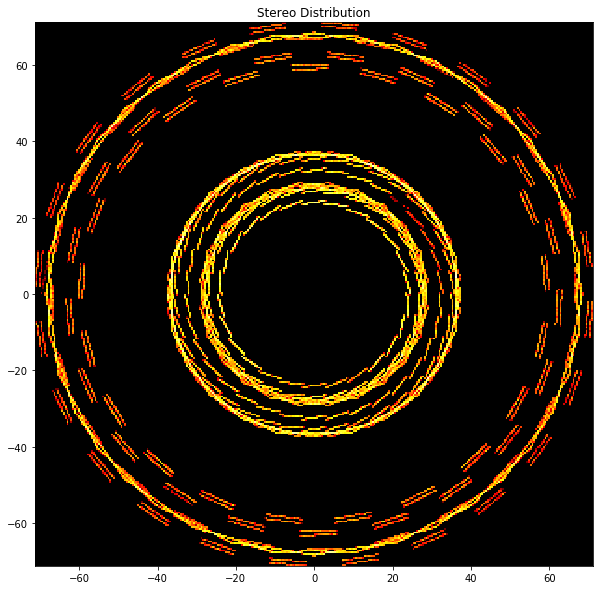

In [47]:
%matplotlib inline
# ToDo: Add lognorm colormap

stereo_x_ = data_.array("stereoHitX") 
stereo_y_ = data_.array("stereoHitY")
stereo_z_ = data_.array("stereoHitZ")

if len(mono_x_) == len(mono_y_):
    concat_stereo_x_ = []
    concat_stereo_y_ = []

    for i in range(len(mono_x_)):
        concat_stereo_x_.extend(stereo_x_[i])
        concat_stereo_y_.extend(stereo_y_[i])

plt.figure(figsize=(10,10))
ax_ = plt.subplot(1,1,1)
# Plot the 2D Histogram for Mono Rechits
ax_.set_title('Stereo Distribution')
ax_.patch.set_facecolor('black')
ax_.hist2d(concat_stereo_x_, concat_stereo_y_, bins=300, norm=matplotlib.colors.LogNorm(), cmap='hot')
plt.savefig('plots/' + gen_event_ + '/stereo/rechitdistribution')
plt.show()

<Figure size 432x288 with 0 Axes>

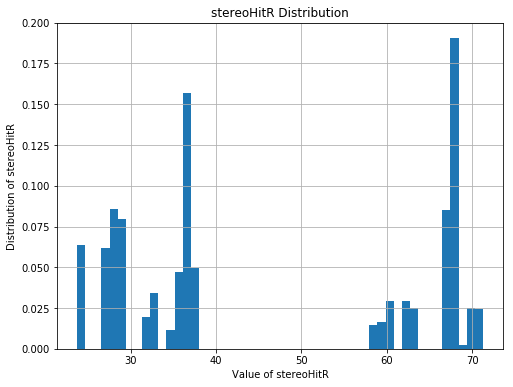

<Figure size 432x288 with 0 Axes>

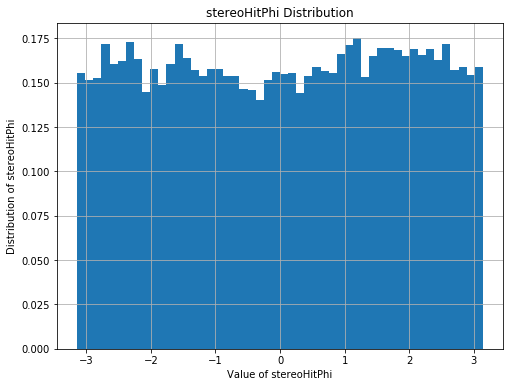

<Figure size 432x288 with 0 Axes>

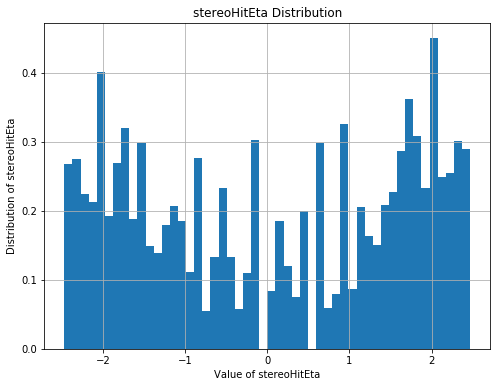

In [48]:
# Define a loop that plots R, Phi, and Eta for Stereo Hits

for param in ["stereoHitR", "stereoHitPhi", "stereoHitEta"]:
    stereo_param_ = data_.array(param)
    concat_stereo_param_ = []
    
    for i in range(len(mono_param_)):
            concat_stereo_param_.extend(stereo_param_[i])

    plt.clf()
    fig, ax_ = plt.subplots(figsize=(8, 6))
    position_ += 1
    # Plot the 2D Histogram for Mono Rechits
    ax_.set_title('StereoRechit Distribution of ' + param)
    ax_.hist(concat_stereo_param_, bins=50, histtype='stepfilled', align='mid', orientation='vertical', density=True)
    plt.xlabel('Value of ' + param)
    plt.ylabel('Distribution of ' + param)
    plt.title(param + ' Distribution')
    plt.grid(True)
    plt.savefig('plots/' + gen_event_ + '/stereo/' + param)
    plt.show()

### Testing Integrity of internal data storage 

In [49]:
%%time
# Correlate the above data to confirm the dataframe is correct
# TODO: Delete above code block as it takes too much time
hit_tp_count_ = {}

for id_, tp_idx_list_ in rechit_global_df_["rechit_tp_index"].items():
    tp_len_ = len(tp_idx_list_)
    if tp_len_ in hit_tp_count_:
        hit_tp_count_[tp_len_] += 1
    else:
        hit_tp_count_[tp_len_] = 1
print hit_tp_count_

{0: 166358, 1: 429164, 2: 4501, 3: 253, 4: 42, 5: 13, 6: 6, 7: 4, 8: 2, 9: 4}
CPU times: user 235 ms, sys: 9.26 ms, total: 245 ms
Wall time: 251 ms


In [50]:
# Check that the same number of entries are recorded for stereo rechits
concat_stereo_tp_idx_ = []
for i in range(len(stereo_tp_idx_)):
    concat_stereo_tp_idx_.extend(stereo_tp_idx_[i])
    
print len(concat_stereo_tp_idx_) == len(concat_stereo_param_)

True
